In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq
import seaborn as sns

<h3>Step 1 - Build likelihood function:</h3>
The simplest Likelihood function (without considering nuisance parameters) is given by:

$$ L(\mu) = \frac{(\mu s + b)^{n}}{n!}e^{-(\mu s + b)} $$


In [2]:
# define factorial
# likelihood function
def likelihood(n:list, nb, ns, mu:list) -> list:
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events (numpy array)
    nb : # of background events
    ns : # of signal events
    mu : strength parameter (numpy array)
    '''
    ntot = nb + mu*ns
    prob = poisson.pmf(n, ntot)
#     prob = ntot**n * np.exp(-(ntot)) / factorial(ntot)
    
    return prob

In [3]:
def muHat(n, nb, ns):
    
    muHat = (n - nb)/ns
    
    return muHat

In [4]:
def likelihoodRatio(n, nb, ns, mu):
    
    L = likelihood(n, nb, ns, mu)
    Lmax = likelihood(n, nb, ns, muHat(n, nb, ns))
    
    return L/Lmax

In [5]:
def qtest(n, nb, ns, allowNegativeMu=False):
    
    mu = np.array([1.]*len(n))
    
    if not allowNegativeMu:
        q = np.where(muHat(n, nb, ns)>0, -2.*np.log(likelihoodRatio(n, nb, ns, mu)), 0.)
        
    else:
        q = -2.*np.log(likelihoodRatio(n, nb, ns, mu))
        
    return q

In [6]:
# Set known values
ns = 14.933117
nb = 38.836
mu = 1.
nobs = 40.
nsim = int(1e7)

# Generate samples under null hypothesis
def genData(mu, nb, ns, nsim):
    ngen = np.random.poisson(lam=mu*ns+nb, size=nsim) 
    return ngen


pseudoN = genData(mu, nb, ns, nsim)

In [7]:
negativeMu = True
q0 = qtest(pseudoN, nb, ns, negativeMu)
negativeMu = False
q0B = qtest(pseudoN, nb, ns, negativeMu)

In [8]:
qobs = qtest(np.array([nobs]), nb, ns)
qvals = np.linspace(q0.min(), q0.max(), 100)

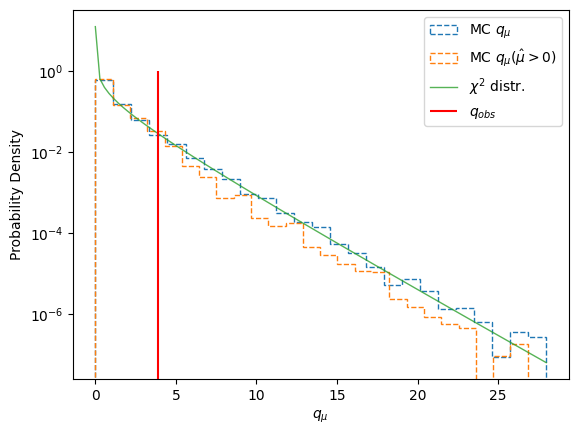

In [9]:
# Plot histogram
hist = plt.hist(q0, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
histB = plt.hist(q0B, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu} (\hat{\mu}>0)$')
plt.plot(qvals, chi2.pdf(qvals, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')
plt.vlines(qobs, 0, 1, 'red', label=r'$q_{obs}$')

plt.legend()
plt.ylabel('Probability Density')
plt.xlabel(r'$q_{\mu}$')
plt.yscale('log')
plt.show()

In [10]:
# p-value from histogram
pval_mc = len(q0[q0>=qobs])/len(q0)
pval_mcB = len(q0B[q0B>=qobs])/len(q0)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print(r'p-value following MC method:', pval_mc)
print(r'p-value following MC method (mu>0):', pval_mcB)
print('p-value from chi squared distribution:', float(pval_chi))

p-value following MC method: 0.0563991
p-value following MC method (mu>0): 0.04146
p-value from chi squared distribution: 0.04907900657964037


<h3>Step 2 - Find $\mu^{95\%}$</h3>
We try to find the value of $\mu$ that excludes the hypothesis at a 95% confidence level

In [11]:
cl = .95 # Confidence level
alpha = 1 - cl # Type 1 error

In [12]:
# Using chi squared method:
cdf = lambda t: 1 - chi2.cdf(t, 1) - alpha
t95 = root(cdf, 0).x

t_func = lambda mu: -2.*np.log(likelihoodRatio(nobs, nb, ns, mu)) - t95
mu95 = float(root(t_func, 1).x)
print(mu95)

0.9959151277832176


Let us now test different values of b:

In [13]:
s = 33.9
bList = [725., 299.9, 148.7, 69.7, 34.5, 32.3]
nobsList = [721., 298., 146., 65., 39., 35.]
mu = 1.
nsim = int(1e6)

In [14]:
qList, qobsList = [], []
for i, b in enumerate(bList):
    qList.append(qtest(genData(mu, b, s, nsim), b, s, True))
    qobsList.append(qtest(np.full(nsim, nobsList[i]), b, s, True)[1])

In [15]:
pList = []
for i, q in enumerate(qList):
    pList.append(len(q[q>=qobsList[i]])/len(qList[i]))

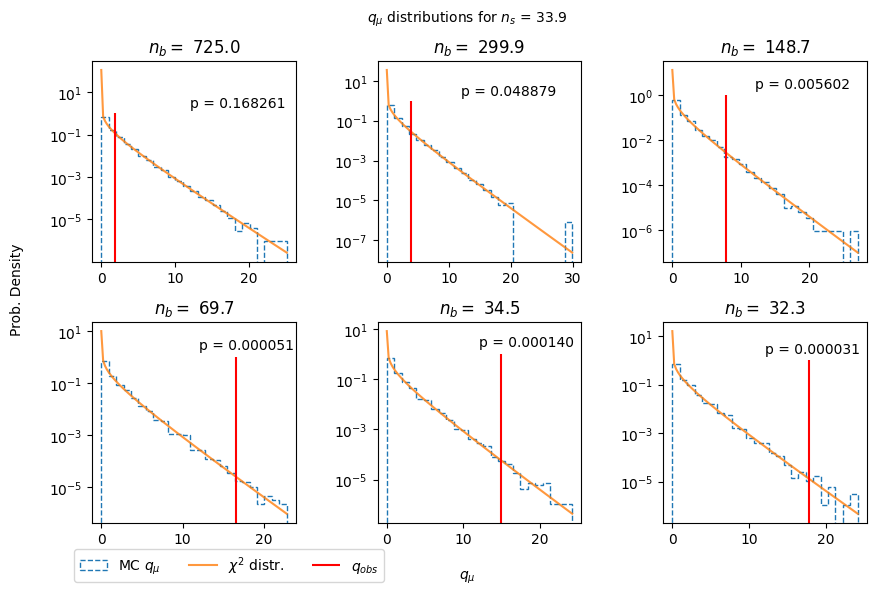

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax = ax.flatten()

for i, a in enumerate(ax):
    a.hist(qList[i], bins=25, density=True, histtype='step', linestyle='--')
    a.plot(np.linspace(qList[i].min(), qList[i].max(), 100), 
             chi2.pdf(np.linspace(qList[i].min(), qList[i].max(), 100), df=1), 
             alpha=0.8)
    a.vlines(qobsList[i], 0, 1, 'red')
    
    a.text(12, 2, r'p = %f' %pList[i])
    a.set_yscale('log')
    
    a.set_title(r'$n_{b}=$ %1.1f' %bList[i])
    

labels = [r'MC $q_{\mu}$', r'$\chi^{2}$ distr.', r'$q_{obs}$']

fig.legend(labels, loc='lower left', bbox_to_anchor=(0.1,0), ncol=len(labels), bbox_transform=fig.transFigure)
fig.text(0.5, 0.95, r'$q_{\mu}$ distributions for $n_{s}$ = %1.1f' %s, ha='center', va='center') # title
fig.text(0.5, 0.02, r'$q_{\mu}$', ha='center', va='center') # x label
fig.text(0.05, 0.5, 'Prob. Density', ha='center', va='center', rotation='vertical') # y label
fig.subplots_adjust(hspace=0.3, wspace=0.4)

plt.show()

<h3>Step 3 - Add uncertainties</h3>
Taking into consideration the uncertainties in the background estimation, now the likelihood function is given by:
\[ L(\mu, \theta) = \frac{(\mu \cdot s + b + \theta)^{n} e^{-(\mu \cdot s + b + \theta)}}{\sqrt{2 \pi}\sigma_{b}n!} \times \exp\left(- \frac{\theta^{2}}{2\sigma_{b}^{2}}\right) \]

In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq
import seaborn as sns

In [2]:
def poissonDist(n, ntot):
    p = poisson.pmf(n, ntot)
    return p

In [3]:
def gaussianDist(theta, sigmab):
    g = norm.pdf(theta, loc=0., scale=sigmab)
    return g

In [4]:
def likelihood(n:list, nb, ns, mu:list, theta:list, sigmab) -> list:
    
    ntot = mu*ns + nb + theta
    
    likelihood = poissonDist(n, ntot)*gaussianDist(theta, sigmab)
    return likelihood

The hypothesis test is given by:

$$ q_{\mu} = -2\log \lambda(\mu) = -2\log \left[ \frac{L(\mu, \hat{\theta})}{L(\hat{\mu},\hat{\hat{\theta}})} \right], $$
where $\hat{\mu}$ and $\hat{\hat{\theta}}$ are the values of $\mu$ and $\theta$, respectively, that maximize the likelihood, and $\hat{\theta}$ is the value of $\theta$ that maximizes the likelihood for a fixed value of $\mu$.

In [5]:
def muHat(n, nb, ns, theta):
    
    muhat = (n - nb - theta)/ns
    
    return muhat

In [6]:
def thetaHat(n, nb, ns, mu, sigmab):
    
    ntot = mu*ns + nb
    theta = - (1/2.)*(ntot + sigmab**2) + (1/2.)*np.sqrt((ntot + sigmab**2)**2 + 4.*sigmab**2*(n - ntot))
    
    return theta

In [7]:
def likelihoodRatio(n, nb, ns, mu, theta, sigmab):
    
    Lmu = likelihood(n, nb, ns, mu, thetaHat(n, nb, ns, mu, sigmab), sigmab)
    Lmax = likelihood(n, nb, ns, muHat(n, nb, ns, theta), thetaHat(n, nb, ns, 1., sigmab), sigmab)
     
    return Lmu/Lmax

In [8]:
def qtest(n, nb, ns, theta, sigmab, mu, allowNegativeMu=False):
    
#     mu = np.array([1.]*len(n))
    
    if not allowNegativeMu:
        q = np.where(muHat(n, nb, ns, theta)>0, -2.*np.log(likelihoodRatio(n, nb, ns, mu, theta, sigmab)), 0.)
        
    else:
        q = -2.*np.log(likelihoodRatio(n, nb, ns, mu, theta, sigmab))
        
    return q
    
    

In [9]:
def loglikelihood(n, nb, ns, mu, theta, sigmab):
    
    ntot = mu*ns + nb
    ll = n*np.log(ntot + theta) - ntot + theta - theta**2/(2*sigmab**2) 
    
    return ll

In [10]:
# Set known values
ns = 14.933117
nb = 38.836
mu = 1.
nobs = 40
nsim = int(1e7)

sigmab = 2.4198 # standard deviation for background uncertainty

pseudotheta = np.random.normal(loc=0., scale=sigmab, size=nsim)
pseudoN = np.random.poisson(lam=mu*ns+nb, size=nsim)

In [11]:
qmu = -2.*loglikelihood(pseudoN, nb, ns, mu, thetaHat(pseudoN, nb, ns, mu, sigmab), sigmab) + \
        2.*loglikelihood(pseudoN, nb, ns, muHat(pseudoN, nb, ns, pseudotheta), \
                         thetaHat(pseudoN, nb, ns, 0., sigmab), sigmab)

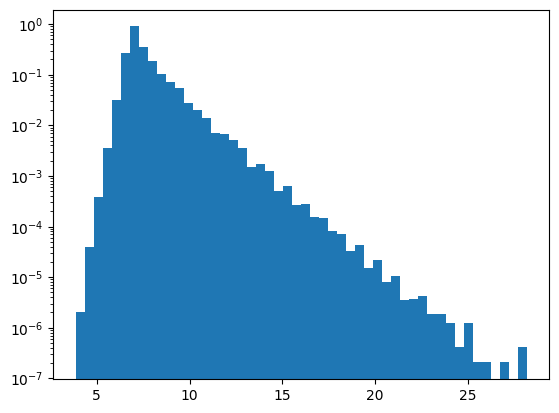

In [12]:
plt.hist(qmu, bins=50, density=True)

plt.yscale('log')
plt.show()

In [13]:
negativeMu = True
test = qtest(pseudoN, nb, ns, pseudotheta, sigmab, np.array([1.]*nsim), negativeMu)

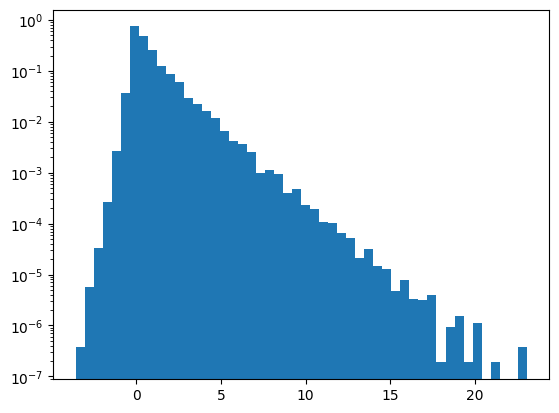

In [14]:
plt.hist(test, bins=50, density=True)

plt.yscale('log')
plt.show()

In [15]:
muList = np.linspace(-0.5, 2, nsim)
nList = np.array(nsim*[nobs])
Lsimp = qtest(nList, nb, ns, 0., 1/math.sqrt(2*math.pi), muList, negativeMu)
Lfull = qtest(nList, nb, ns, sigmab, sigmab, muList, negativeMu)

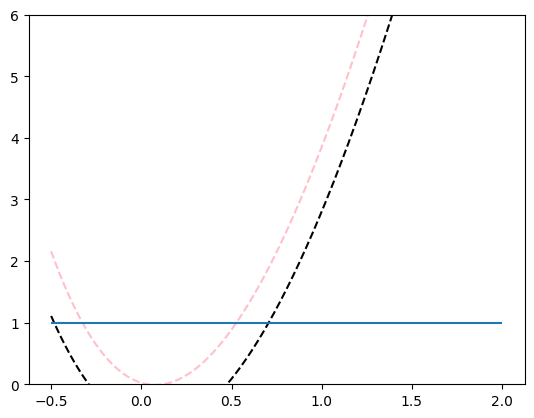

In [16]:
plt.plot(muList, Lsimp, linestyle='--', color='pink')
plt.plot(muList, Lfull, linestyle='--', color='black')
plt.hlines(1, -.5, 2)

plt.ylim([0, 6])
# plt.yscale('log')
plt.show()

In [17]:
def qmu(n, nb, ns, mu, theta, sigmab):
    
    q1 = 2.*n*(np.log(muHat(n, nb, ns, theta)*ns + nb + thetaHat(n, nb, ns, 1., sigmab)) - 
               np.log(mu*ns + nb + thetaHat(n, nb, ns, mu, sigmab))) + \
         2*(ns*(mu - muHat(n, nb, ns, theta)) + 
            thetaHat(n, nb, ns, mu, sigmab)) - thetaHat(n, nb, ns, 1., sigmab)  + \
         (thetaHat(n, nb, ns, mu, sigmab)**2 - thetaHat(n, nb, ns, 1., sigmab)**2)/sigmab**2
    
    q = np.where(muHat(n, nb, ns, theta)>0, q1, 0)
    
    return q

In [18]:
qmu = qmu(pseudoN, nb, ns, mu, pseudotheta, sigmab)

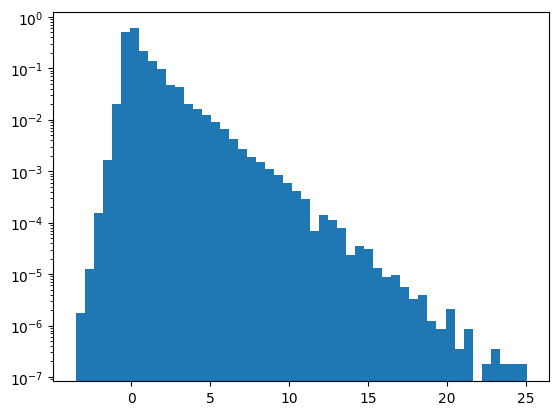

In [19]:
plt.hist(qmu, bins=50, density=True)

plt.yscale('log')
plt.show()